In [37]:
from utilities.constants import *
from utilities.temporal_analysis import *
import matplotlib.pyplot as plt
from utilities.model_matching_computation import *
from utilities.features_eng import *
import pandas as pd
from music21 import *
from utilities.corpus_search import *
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

le = LabelEncoder()
df_notes = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')
#df_notes = get_timestamps_from_all_corpus()
df_notes['tie'] = df_notes['tie'].fillna(-1)

df_notes = df_notes.dropna()
df_notes['NoteAndRest'] = df_notes['NoteAndRest'].apply(lambda x: re.sub(r'\d+', '', x))
df_notes['quarterLength'] = [0.33 if i == '1/3' else i for i in df_notes['quarterLength']]
df_notes['offset'] = [8/3 if i == '8/3' else i for i in df_notes['offset']]
df_notes['offset'] = [7/3 if i == '7/3' else i for i in df_notes['offset']]

df_notes = label_length(df_notes)
keys_to_encode = df_notes['key'].apply(lambda x: str(x)).tolist()
df_notes['key'] =  le.fit_transform(keys_to_encode)
df_notes = df_notes[df_notes['length_section'] > 30]


Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:
Precision: 0.848134
Weighted recall for each class: 0.821435
Global recall: 0.848134
F1 score: 0.848134


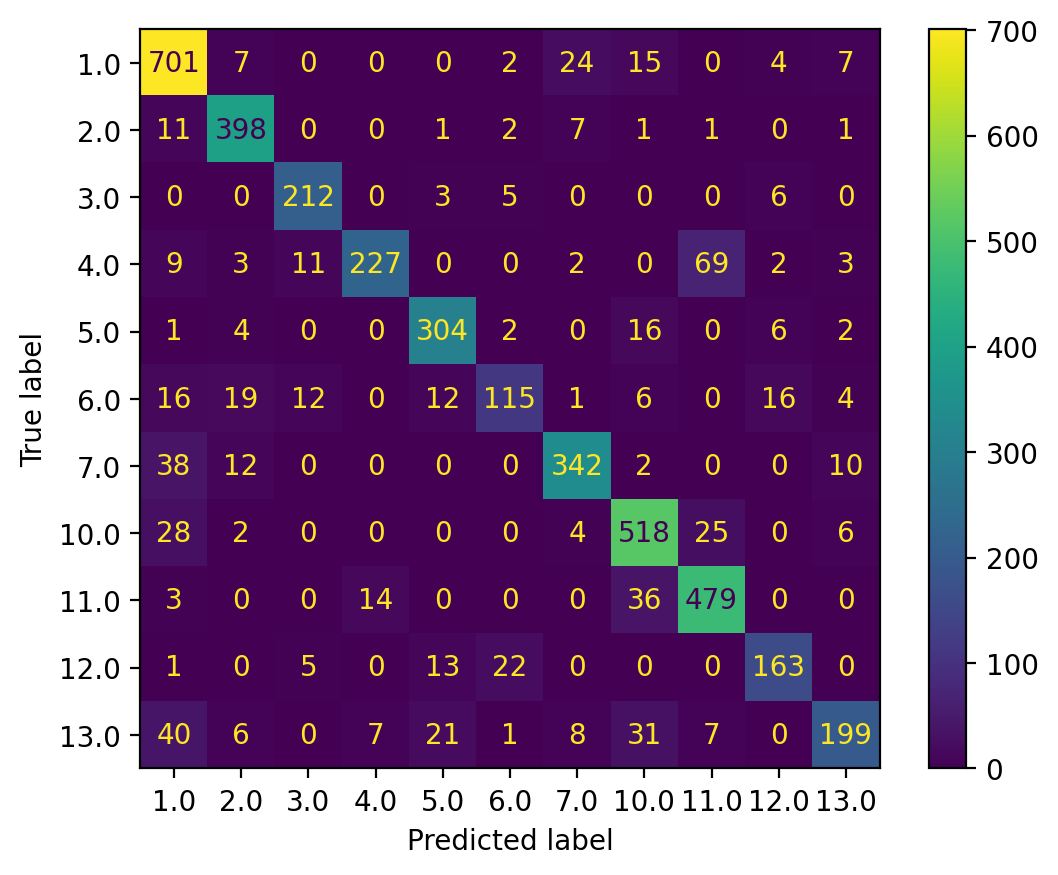

In [41]:
label = 'nawba'
length_param = [256, 512, 1024]
stride_param = [True, False]
random_state = 42
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt', 'log2', None]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
import warnings
warnings.filterwarnings("ignore")

# Function to convert note and octave to MIDI number
df_windowed = return_windowed_df(df_notes, ['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', 'tie', 'nawba', 'mizan', 'tab'], label, apply_stride=True, length_sequence=256)
# Create new dataset with translated notes to pitch
df_midi = df_windowed.copy()

df_midi = df_midi[df_midi['length_section'] > 30]
df_midi['NoteAndRest'] = df_midi['NoteAndRest'].apply(lambda x: note_to_midi(x))
df = df_midi[df_midi[label].isin(LABEL_LIST_TRAIN[label])]
pitch_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(compute_avg_folded_hist_labeled_notes(x['NoteAndRest'].tolist(), x['quarterLength'].tolist())))
ql_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(get_folded_rhythm_histogram(x['quarterLength'].tolist())))

to_stratify = []
prefix_to_ids = defaultdict(list)
prev_pref = ""
for id_ in df['section_id'].unique():
    prefix = id_[:PREFIX_LENGTH]
    prefix_to_ids[prefix].append(id_)
    if prev_pref != prefix:
    
        to_stratify.append(df.loc[df['section_id'].str.contains(id_)][label][0].tolist())
        prev_pref = prefix
prefixes = list(prefix_to_ids.keys())


skf = StratifiedKFold(n_splits=10)
prefixes = np.array(prefixes)
pred = []
actual = []
for i, (train_index, test_index) in enumerate(skf.split(prefixes, to_stratify)):
    print(f"Fold {i}:")
    #train_prefixes, test_prefixes = train_test_split(prefixes, stratify=to_stratify, test_size=0.2, random_state=random_state)
    train_prefixes = prefixes[train_index]
    test_prefixes= prefixes[test_index]
    # Step 3: Gather IDs for train and test sets
    train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]
    test_ids = [id_ for prefix in test_prefixes for id_ in prefix_to_ids[prefix]]


    
    #compare_plot_label_distribution(df_windowed, df_notes)
    shuffled_df = df.sample(frac=1, random_state=random_state)
    # Group by 'section_id'
    grouped = shuffled_df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', label]]
    # Create an array for each group

    group_arrays = {section_id: group.values for section_id, group in grouped}
    avg_sequence_length = 0
    sequences_features = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for key, values in group_arrays.items():
        if key in train_ids:
            X_train.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
            y_train.append((values[0][-1]))
        else:
            X_test.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
            y_test.append((values[0][-1]))

        sequences_features.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))

        avg_sequence_length += len(values) 

    sequences_features = [list(x.values()) for x in sequences_features]
    X_train = [list(x.values()) for x in X_train]
    X_test = [list(x.values()) for x in X_test]

    """
    num_train = []
    num_test = []
    for y in LABEL_LIST_TRAIN[label]:
        num_train.append(len([x for x in y_train if x == y]))
        num_test.append(len([x for x in y_test if x == y]))
    plt.bar(LABEL_LIST_TRAIN[label], num_train, label ="Train")
    plt.bar(LABEL_LIST_TRAIN[label], num_test, label ="Test")
    """

    """
    # Your features and labels
    X = sequences_features
    y = list(df.groupby("section_id", group_keys=True)[label].first())  
    for m in LABEL_LIST_TRAIN[label]:
        print(m, len([x for x in y if x == m]))  
    """
    """
    clf = RandomForestClassifier()
    # Initialization of hyperparameter choice
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['sqrt', 'log2', None]
    criterion = ['gini', 'entropy', 'log_loss']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'criterion': criterion,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 10, random_state=random_state, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    best_params = rf_random.best_params_"""
    
    """
    # Your features and labels
    X = sequences_features
    y = list(df.groupby("section_id", group_keys=True)[label].first())    
    # For Mizan
    clf = RandomForestClassifier(n_estimators=600, random_state=random_state, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=70,  bootstrap=True, criterion='log_loss')
    # For Nawba
    #clf = RandomForestClassifier(n_estimators=200, random_state=random_state, min_samples_split=10, min_samples_leaf=1, max_features='log2', max_depth=30,  bootstrap=False, criterion='log_loss')
    # For Tab

    cv_scores = cross_val_score(clf, X, y, cv= 50)
    # Print individual scores and average
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.2, random_state=random_state)"""
    clf = RandomForestClassifier(n_estimators=600, random_state=random_state, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth = None, bootstrap=False, criterion= 'gini')
    clf.fit(X_train, y_train)
    pred.extend(clf.predict(X_test))
    actual.extend(y_test)
    #print_performance(y_test, clf.predict(X_test), cv_scores)
    #print_performance(y_test, clf.predict(X_test))
print_performance(actual, pred)
